In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from numpy import random as rnd 
import seaborn as sns

## Start by just simulating some place cell data

- Per map, assign cell to have place field w/ x% probability 
    - Start w/ uniform, then allow for reward overreprepresentation
- Poisson or negative binomial noise
- Assuming a fixed, abrupt transition between maps 
- Then use HMM model of hippocampus, w/ remapping fraction correlated w/ probability of being in either map 
    - can just do some kind of unsupervised inference problem? like gaussian hmm 

$$r = W_{Z} * X $$

$$Y = Poi(r) $$

Where $r =$ rate, $W = $ neural tuning, $Z = $ context, $X = $ position, $Y = $ observed firing rate

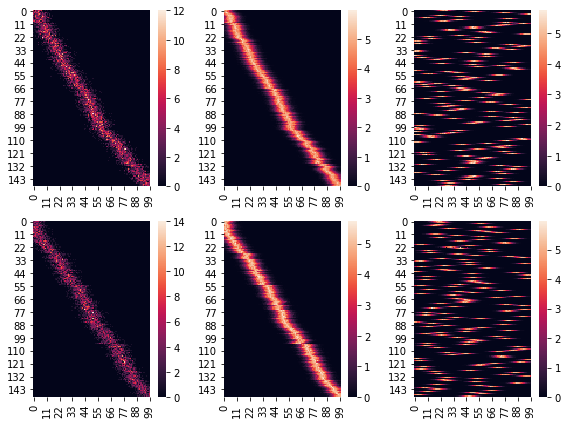

In [48]:
# parameters
n_trials = 120 
switch_trial = 70
n_posBins = 100 
n_neurons = 150
tau = .05
gain = 5

# define tuning function 
W = {}
W[0] = rnd.rand(n_neurons) * n_posBins 
W[1] = rnd.rand(n_neurons) * n_posBins

# define context
Z = np.concatenate((np.zeros(switch_trial),np.ones(n_trials - switch_trial)))

# define weights per trial 
Wz = np.concatenate([W[z][np.newaxis,:] for z in Z])

# define stimulus - just sweeping over positions
X = np.linspace(0,n_posBins,n_posBins)
                
# Make firing rate and add noise
r = gain * np.exp(-0.5 * tau * ( np.tile(X[:,np.newaxis],(n_trials,1,n_neurons)) - np.tile(Wz[:,np.newaxis,:],(1,n_posBins,1)))**2 )
y = rnd.poisson(r) 

# get peaksort for visualization 
peaks0 = np.argmax(y[Z == 0,:,:].mean(axis = 0),axis = 0)
peaksort0 = np.argsort(peaks0)
peaks1 = np.argmax(y[Z == 1,:,:].mean(axis = 0),axis = 0)
peaksort1 = np.argsort(peaks1)

# visualize w/ peaksort
fig , ax = plt.subplots(2,3,figsize = (8,6))
sns.heatmap(y[0,:,peaksort0].squeeze(),ax = ax[0,0])
sns.heatmap(y[Z == 0,:,:].mean(axis = 0)[:,peaksort0].T,ax = ax[0,1])
sns.heatmap(y[Z == 1,:,:].mean(axis = 0)[:,peaksort0].T,ax = ax[0,2])
sns.heatmap(y[switch_trial,:,peaksort1].squeeze(),ax = ax[1,0])
sns.heatmap(y[Z == 1,:,:].mean(axis = 0)[:,peaksort1].T,ax = ax[1,1])
sns.heatmap(y[Z == 0,:,:].mean(axis = 0)[:,peaksort1].T,ax = ax[1,2])
fig.tight_layout()


In [37]:
Wz.shape

(100, 150)

In [32]:
X = np.tile(np.linspace(0,1,n_posBins)[:,np.newaxis],(n_trials,1,n_neurons))
X.shape

(200, 100, 150)